# Author Analysis
### This notebook is a quick NLP analysis of different authors' writing styles. It examines lexical similarity between authors through two types of clustering, and then similarity through other stylistic features such as punctuation profies and part-of-speech use. Last, it looks into an individual author's phrase usage to show how the meaning and style of an individual document can be inferred using these same techniques. All data comes from Project Gutenberg.

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.porter import *
from sklearn.cluster import KMeans
import os
from scipy.spatial.distance import cdist, pdist
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
documents = []
names = []
docsDir = "/Users/jamesledoux/Documents/data_exploration/author_files"
for book in os.listdir(docsDir):
    if not book.startswith('.'):    #pass hidden files such as .DS_STORE
        book = str(book) #file name
        names.append(book)
        with open("/Users/jamesledoux/Documents/data_exploration/author_files/" + book, 'rb') as f:
            content = f.read() #.splitlines()
            content = unicode(content, errors='replace')
            documents.append(content)
print str(len(documents)) + " documents loaded"

74 documents loaded


#Content Clustering

### In this step I look to see if there are any obvious clusters in the data based on the word choice of the authors. To do this, I:

**1:** Tokenize and stem the documents, in order to reduce words to their stems (i.e. removing "ing," "ed," "ey" from words to reduce them to their root word), and put them into vectorized format 

**2:** Calculate tf-idf scores. This score (term frequency x inverse document frequency) captures which words an author uses disproportionately more than every other author, thus capturing the language that makes their work unique

**3:** Run a k-means clustering model on the authors' tf-idf scores, clustering authors by their vocabularies

**4:** Evaluate the k-means model by seeing how much additional variance is explained by each added cluster, in order to see how many clusters might exist inside the data. If there is a clear "elbow" in this graph, where the slope flattens, then this is likely the number of clusters that exists.

In [3]:
stemmer = PorterStemmer()
token_docs = [nltk.word_tokenize(document) for document in documents]
token_docs = [[stemmer.stem(token) for token in doc] for doc in token_docs] #now stemmed. slow but worth it
token_docs  = [" ".join(i) for i in token_docs]
print "documents tokenized and stemmed"

documents tokenized and stemmed


In [4]:
tfidf = TfidfVectorizer(ngram_range=(1, 1),
                        stop_words='english',
                        strip_accents='unicode', analyzer = 'word',
                        max_features=1500,
                        min_df=2)  #should we ease up on this max df?

tfidf_matrix =  tfidf.fit_transform(token_docs)
feature_names = tfidf.get_feature_names() 
print "tfidf calculated"

tfidf calculated


In [5]:
K = range(1,20) #k-means k values to test
KM = [KMeans(n_clusters=k).fit(tfidf_matrix) for k in K] #fit k-means model for each k in K
centroids = [k.cluster_centers_ for k in KM]
print "k-means models complete"

k-means models complete


In [6]:
X = tfidf_matrix.todense()
distances = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(d,axis=1) for d in distances]
dist = [np.min(d,axis=1) for d in distances]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(X)**2)/X.shape[0]
bss = tss-wcss

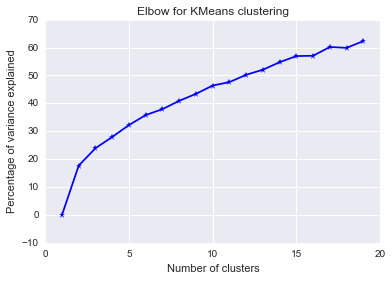

In [7]:
#elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')

### The above K-Means resuilts were not too promising, since there is no real "elbow" in the above curve. Let's try a different type of clustering: hierarchical. 

 The hierarchical clustering takes the tf-idf scores for each author and breaks them into clusters based on similar word use. This goes a step beyond the k-means model, however, in that it then looks into which clusters are most similar to one another, giving a hierarchy of similarities between authors and author groups. The tree-graph (dendrogram) this produces below shows the similarity (or lack thereof) between any two authors in the data.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


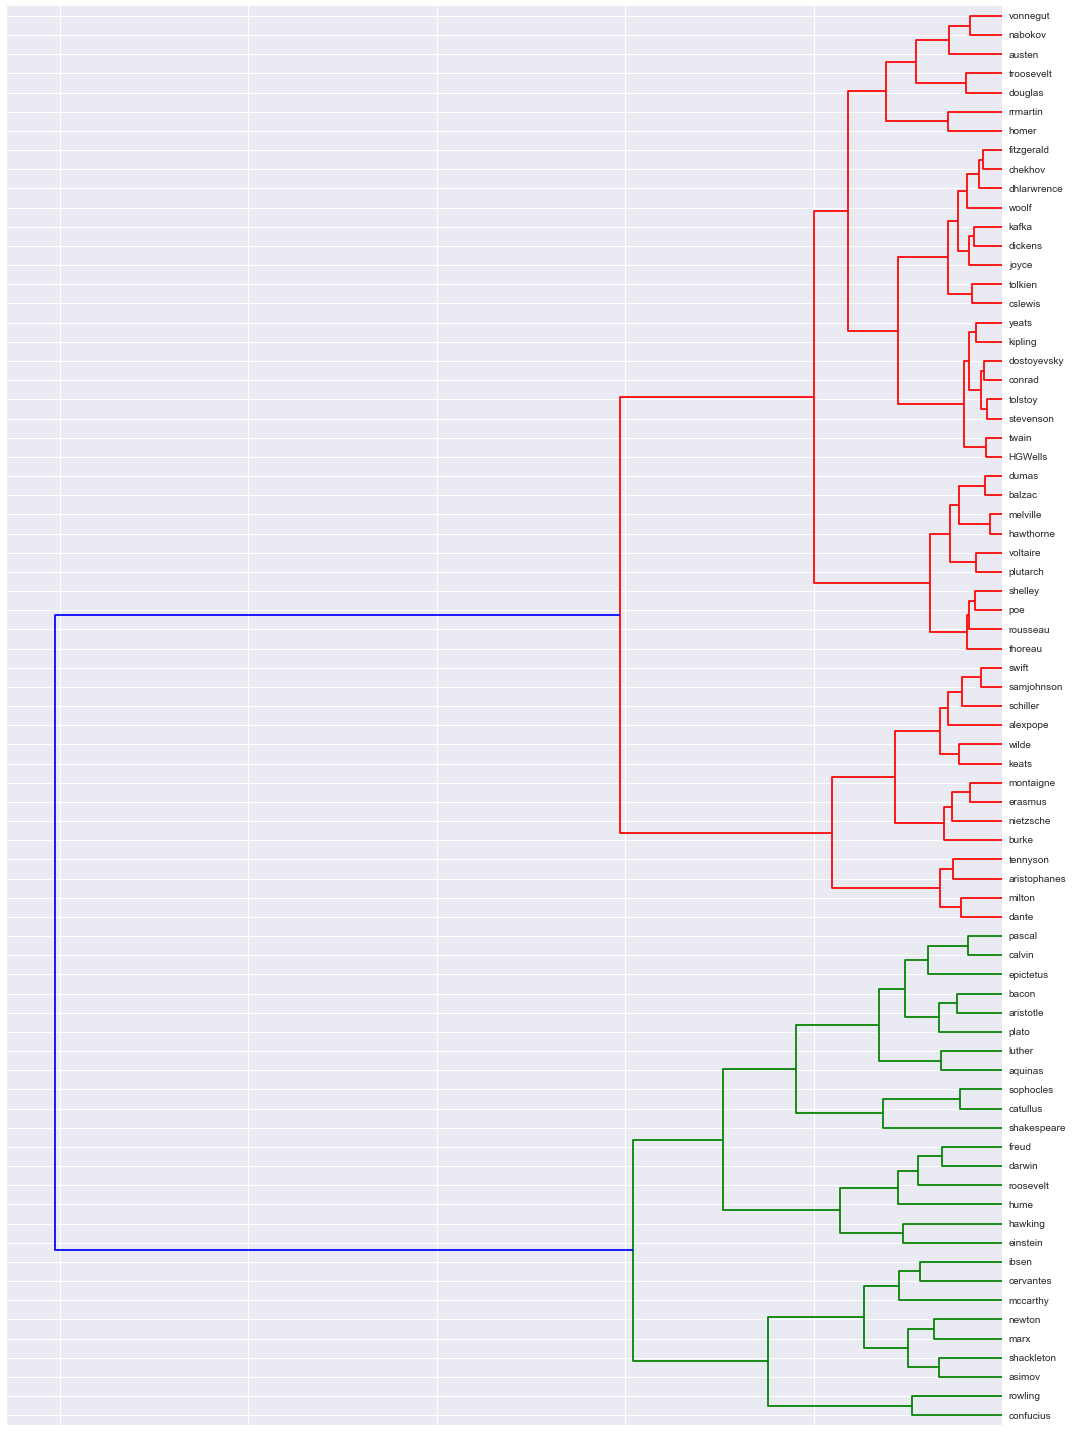

In [8]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=names);

plt.tick_params(\
    axis= 'x',         
    which='both',      
    bottom='off',      
    top='off',        
    labelbottom='off')

plt.tight_layout()

### K-Means Result
The line graph shows the variance explained by the k-means model for each number of clusters tested. The steadily-increasing pattern suggests that there is no clear answer to how many vocabulary-based clusters exist in the data available. This suggests that more authors would be needed in order to get a useful result for vocabulary-based clustering.

### Hierarchical Result
The hierarchical figure shows something more interesting. You can see, for example, that Pascal and Calvin belong to the same cluster, being that they are both prominent religous figures. That particular cluster, however, is then related to another cluster containing Epictetus, Aristotle, and Plato, showing a higher-level connection between religious and classical philosophy. The tree advances forward from there, showing the most and least similar groupings of topics. Many of the clusters in this graph and their associations with other clusters make intuitive sense, providing an interesting insight into the artistic similarity between many of these writers.

#Feature Profiles

Next I take a deeper look into the features that characterize each author's work. I have extracted average sentence length, punctuation frequencies, sentiment scores (positive, negative and neutral), and data on part-of-speech usage. The goal here is to place values on the characteristics that come to constitute an author's "style," or voice.

In [62]:
data = pd.read_csv("features.csv")

In [63]:
#drop unneeded or unhelpful columns
names = data['book_name']
drops = ["book_name", "total_words", "Author", "Title", "ID", "%", "$", "&", "/", "<", ">", "+", "#", "@", "]", "~", "^", "{", "LS"]
for i in drops:
    data = data.drop(i, 1)

In [64]:
#aggregate similar part-of-speech features
data['verbs'] = data['VB'] + data['VBD'] + data['VBG'] + data['VBP']
data['nouns'] = data['NN'] + data['NNP'] + data['NNPS'] # ADD 'NNS' BACK IN ONCE IT'S IN THE SCRIPT
data['adjectives'] = data['JJ'] + data['JJR'] + data['JJS']

In [65]:
columns = data.columns
df = data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(df)
data = pd.DataFrame(data_scaled)
data.columns = columns

###First, a look at the population distribution.
The figure below shows a histogram of each feature's values across all authors tested. This is helpful in seeing which features vary across the population, and which are more-or-less the same for each writer. The features that vary are the ones that tell us something interesting about an author. Interestingly, many of these distributions appear to be normal. The feature names can be somewhat cryptic here, but they either represent punctuation use (when the name is a punctuation mark) or part-of-speech use (when the name is an abbreviation).

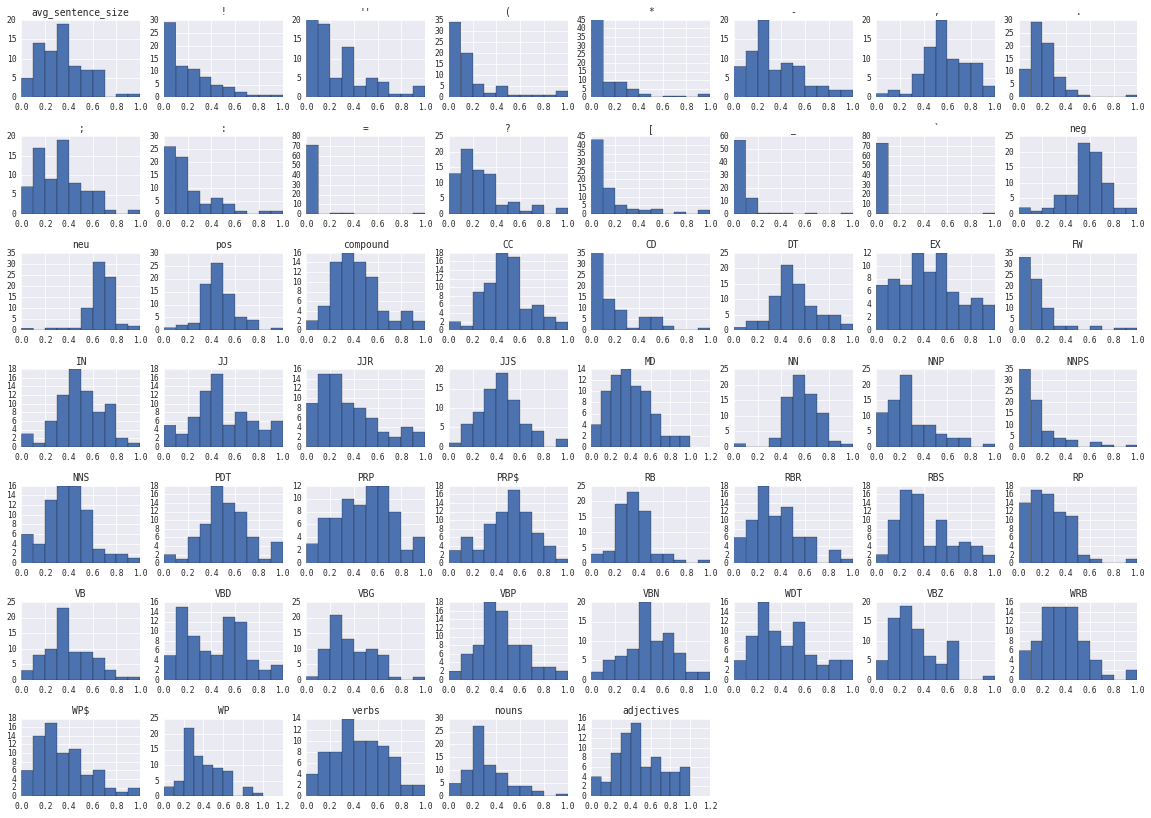

In [66]:
#viewing distributions
cols = data.columns
plt.figure(figsize=(20, 16))

#histograms of all features to understand distributions
for i in range(len(cols)):
    plt.subplot(8,8,i+1)
    lab = cols[i]
    plt.hist(data[lab])
    plt.yscale('linear')
    plt.title(lab)
    plt.grid(True)
    plt.subplots_adjust(hspace=.5)
plt.show()

### Next, a look at which features are correlated.
Red denotes a high positive correlation, blue a high negative correlation, and white shows that there is little-to-no correlation.

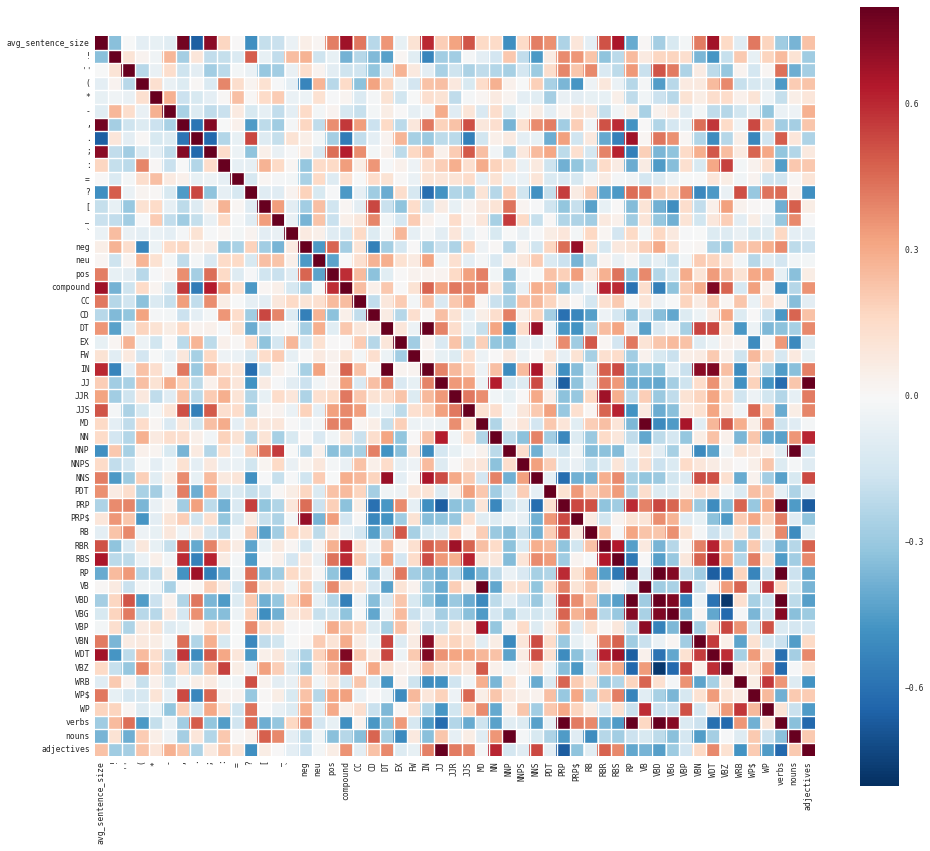

In [74]:
#correaltions between features
sns.set(context="paper", font="monospace")

corrmat = data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 12))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

# Use matplotlib directly to emphasize known networks
networks = corrmat.columns.get_level_values(0)

for i, network in enumerate(networks):
    if i and network != networks[i - 1]:
        ax.axhline(len(networks) - i, c="w")
        ax.axvline(i, c="w")

f.tight_layout()

### Finally, a look at the feature profile that this creates. 
Below I extract some examples of the punctuation and part-of-speech-based feature profiles that have been extracted to this point. By comparing these examples, one can begin to understand the differences in the respective writers' "voices" that, without such data, are challenging to describe.

A brief key on what the variable names mean:
* CD: "cardinal" (use of numbers)
* RB: adverbs
* FW: foreign words
* IN: prepositions and conjunctions
* Punctuation mark: use of that punctuation mark
* Verbs, nouns, adjectives: self explanatory

In [68]:
#features to focus on. CD = "cardinal" (aka numbers). RB = adverbs. FW = foreign word. IN = preposition/conjunction.
pos_viz = ['verbs', 'nouns', 'CD', 'adjectives', 'RB', 'FW', 'IN']
punct_viz = ['!', "''", ':', ',', "?", ';', '(', '.', '-']

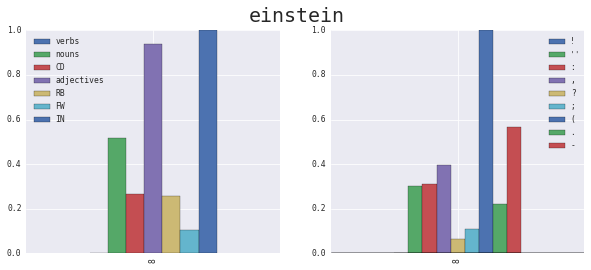

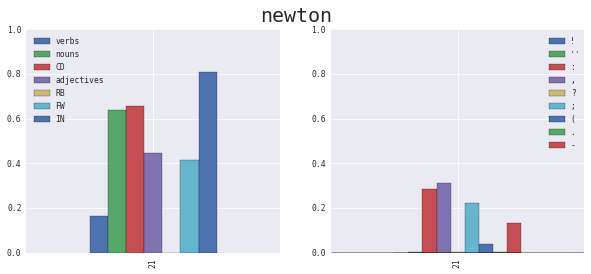

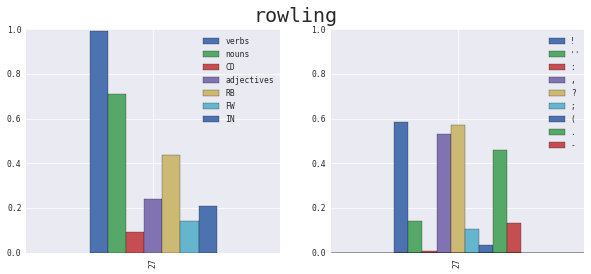

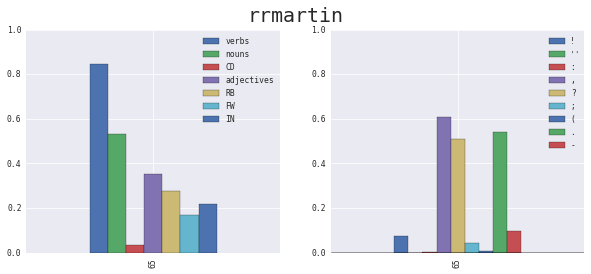

In [69]:
#plot results for these four authors
desired_names = ['rowling', 'rrmartin', 'einstein', 'newton']

for i in range(len(names)):
    if names[i] in desired_names:
        data_viz1 = data[pos_viz][i:i+1] #get one observation with just these columns
        data_viz2 = data[punct_viz][i:i+1] 
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
        plt.suptitle(names[i], fontsize=20)
        data_viz1.plot(ax=axes[0], kind='bar').set_ylim(0,1); plt.axhline(0, color='k')
        data_viz2.plot(ax=axes[1], kind='bar').set_ylim(0,1); plt.axhline(0, color='k')


#Feature Clustering

Next I try the same K-Means method that was used in the content-based clustering, but this time apply it to the stylistic features from the part-of-speech tagging, sentiment analysis, and punctuation profiles that have been extracted in this most recent section.

In [70]:
#drop the aggregate features since they're already represented in the individual variables
verbs, adjectives, nouns = data['verbs'], data['adjectives'], data['nouns']
data = data.drop("verbs", 1)
data = data.drop("adjectives", 1)
data = data.drop("nouns", 1)

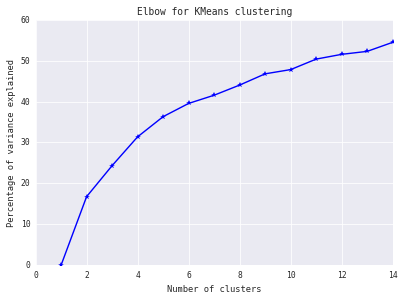

In [38]:
K = range(1,15) #k-means k values to test
KM = [KMeans(n_clusters=k).fit(data) for k in K] #fit k-means model for each k in K
centroids = [k.cluster_centers_ for k in KM]

distances = [cdist(data, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(d,axis=1) for d in distances]
dist = [np.min(d,axis=1) for d in distances]
avgWithinSS = [sum(d)/data.shape[0] for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(data)**2)/data.shape[0]
bss = tss-wcss

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')

#### This k-means model shows a slightly steeper curve as the number of clusters increases, suggesting that the optimal number of clusters is somewhere between 4 and 6, before the slope declines and additional clusters explain a less significant amount of the variance between authors.

In [39]:
names = np.array(names)
labels = KM[4].predict(data)

In [40]:
zero = []
one = []
two = []
three = []
four = []
five = []
for i in range(len(names)):
    if labels[i] == 0:
        zero.append(names[i])
    if labels[i] == 1:
        one.append(names[i])
    if labels[i] == 2:
        two.append(names[i])
    if labels[i] == 3:
        three.append(names[i])
    if labels[i] == 4:
        four.append(names[i])
    if labels[i] == 5:
        five.append(names[i])

###Breaking the data into five clusters, here is how the model separated them. 
This suggests that Darwin, Einstein, Newton and Asimov had similar writing styles to one another, and similarly that Plato and Aristotle wrote similar to one-another as well. This makes intuitive sense, suggesting that there is something that can be learned from clustering on these stylistic features.

In [41]:
print "ZERO: "
print zero

ZERO: 
['conrad', 'dhlarwrence', 'dickens', 'dostoyevsky', 'fitzgerald', 'HGWells', 'homer', 'joyce', 'rowling', 'tolstoy', 'twain', 'woolf', 'yeats', 'austen', 'chekhov', 'cslewis', 'dumas', 'kafka', 'kipling', 'mccarthy', 'nabokov', 'rrmartin', 'stevenson', 'tolkien', 'vonnegut']


In [42]:
print "ONE: "
print one

ONE: 
['asimov', 'darwin', 'einstein', 'newton', 'aquinas', 'hawking']


In [43]:
print "TWO: "
print two

TWO: 
['cervantes', 'dante', 'milton', 'montaigne', 'nietzsche', 'plato', 'samjohnson', 'aristotle', 'bacon', 'calvin', 'hume', 'rousseau']


In [44]:
print "THREE: "
print three

THREE: 
['freud', 'hawthorne', 'melville', 'plutarch', 'poe', 'shelley', 'voltaire', 'alexpope', 'balzac', 'burke', 'douglas', 'marx', 'roosevelt', 'schiller', 'shackleton', 'thoreau', 'troosevelt']


In [45]:
print "FOUR: "
print four

FOUR: 
['epictetus', 'erasmus', 'keats', 'pascal', 'shakespeare', 'sophocles', 'swift', 'wilde', 'aristophanes', 'catullus', 'confucius', 'ibsen', 'luther', 'tennyson']


In [46]:
_centroids = centroids[5]
_centroids.shape
_centroids = pd.DataFrame(_centroids)
columns = data.columns

In [47]:
_centroids.columns = columns

### Feature Profile for each Cluster
Given the above five-cluster model, here is the feature profile that represents each cluster. The values assigned to each variable in these examples collectively represent what makes up the center of that particular cluster. This means that, for each author, whichever of the below feature profiles their own profile is most similar to will be the cluster that they are assigned to. 

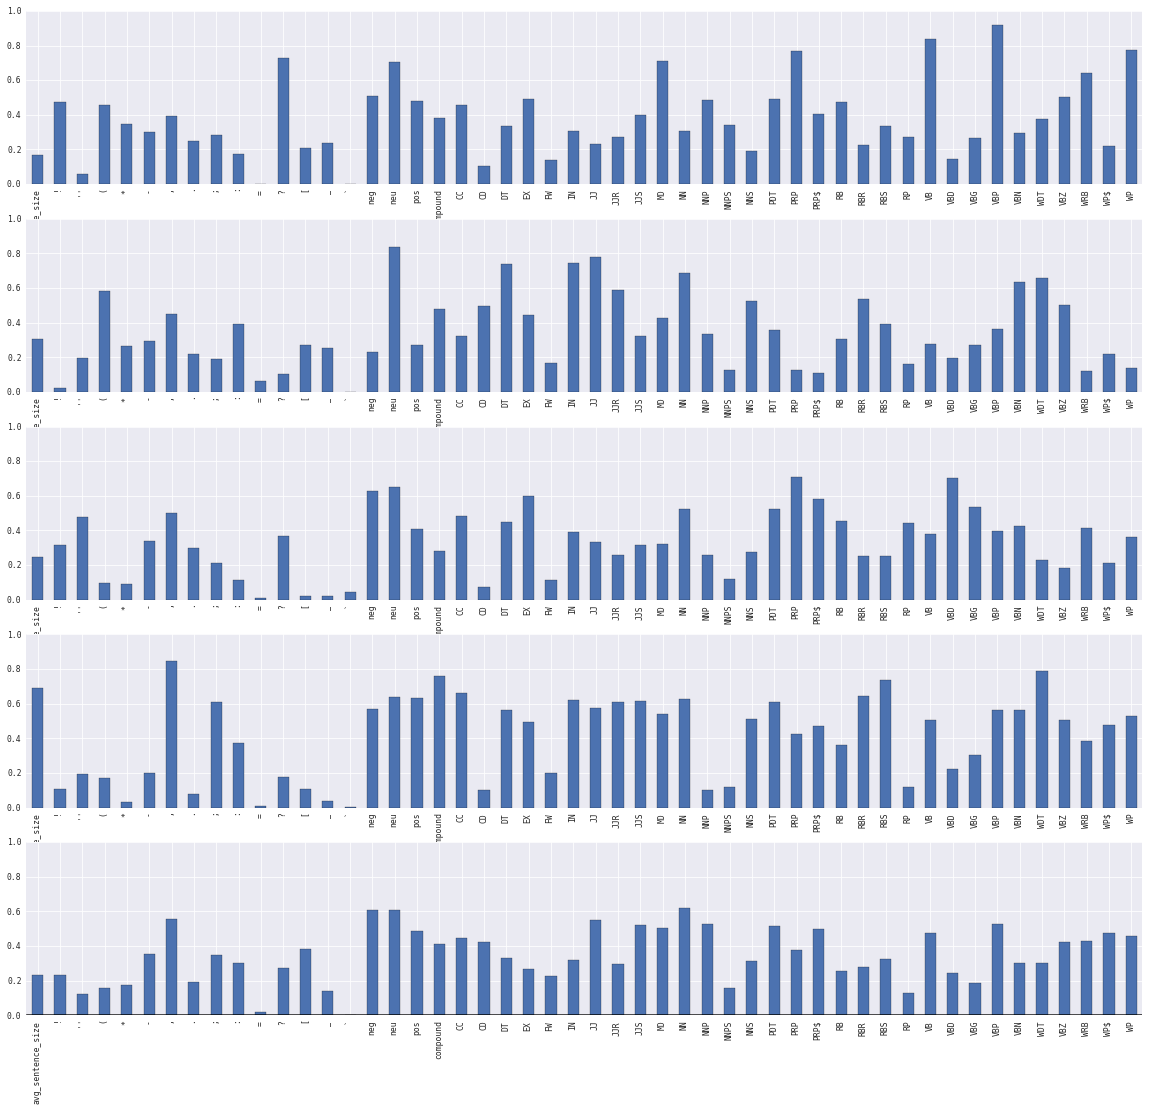

In [78]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20,18))
_centroids.iloc[0].plot(ax=axes[0], kind='bar').set_ylim(0,1); plt.axhline(0, color='k')
_centroids.iloc[1].plot(ax=axes[1], kind='bar').set_ylim(0,1); plt.axhline(0, color='k')
_centroids.iloc[2].plot(ax=axes[2], kind='bar').set_ylim(0,1); plt.axhline(0, color='k')
_centroids.iloc[3].plot(ax=axes[3], kind='bar').set_ylim(0,1); plt.axhline(0, color='k')
_centroids.iloc[4].plot(ax=axes[4], kind='bar').set_ylim(0,1); plt.axhline(0, color='k')

# A Closer Look into an Individual Text

Last I take a closer look into an individual author, seeing his most common words and bi-grams (pairs of words). From this you can gather a basic idea of what the athor writes about. For example, in the case of Stephen Hawking, one can see below that he writes about black holes, the history of time, general relativity, and the big bang.

* First I remove stopwords (i.e. "a," "and," "the," etc.) and punctuation from the text
* Next the document is tokenized
* Finally, I collect frequency distributions of 1 and 2-grams (single words and word pairs), and then plot them

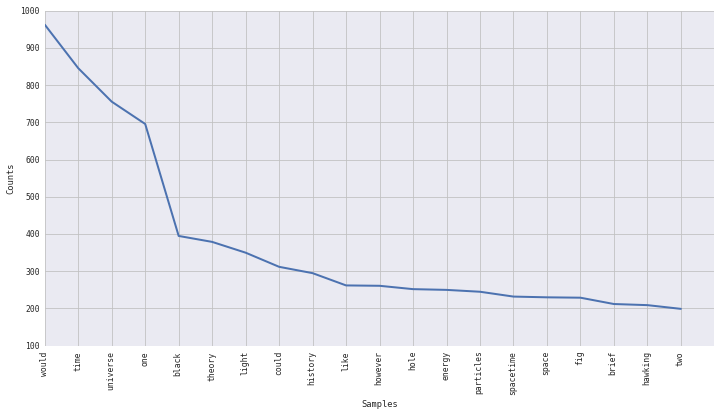

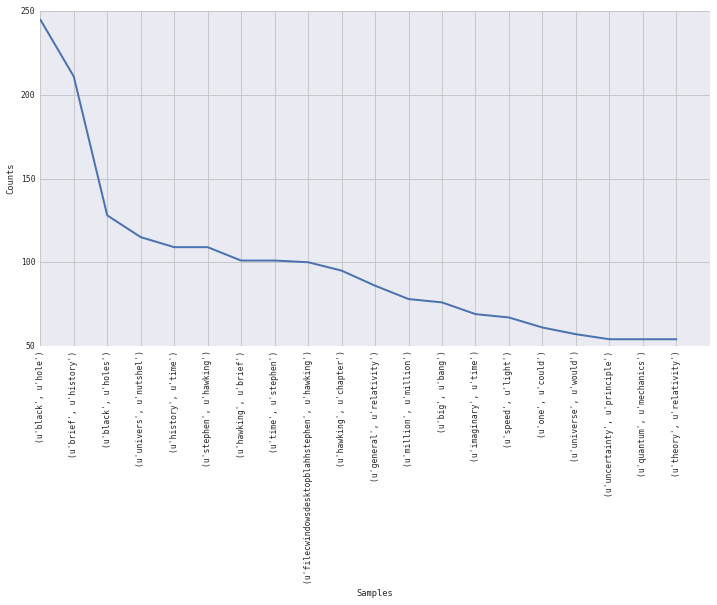

In [49]:
from nltk.corpus import stopwords
import string
from nltk.util import bigrams
from itertools import chain

stoplist = stopwords.words('english')
stoplist = stoplist + ['e', 'u', 'n', 'h', 'i', 'l']  #hawking uses math, and the notation throws off this analysis
doc = documents[28].lower()

#remove punctuation and stopwords, tokenize
exclude = set(string.punctuation)
doc = ''.join(ch for ch in doc if ch not in exclude)
doc = nltk.word_tokenize(doc) #tokenize document
doc = [token for token in doc if token not in stoplist] #remove all stopwords

#plot top words
frequencyDistribution = nltk.FreqDist(doc)
plt.figure(figsize=(12, 6))
# plot the top 20 tokens
frequencyDistribution.plot(20)

#plot top word pairs (bi-grams)
b = list(chain(*[(list(bigrams(doc)))]))
fdist = nltk.FreqDist(b)
plt.figure(figsize=(12, 6))
# plot the top 20 bigrams
fdist.plot(20)

### The clusters calculated earlier are useful here as well. 
Here we can see which other writers Hawking shares a similar style with. According to his stylistic profile, he writers most similar to other scientific writers (Newton, Darwin, Einstein), sci-fi novelists (Asimov), and St. Thomas Acquinas. The religious philosopher Aquinas may be an outlier here, but the majority of these results make sense.

In [51]:
print "similar authors: "
print one

similar authors: 
['asimov', 'darwin', 'einstein', 'newton', 'aquinas', 'hawking']


### Last, we will want to visualize his profile in order to see how he structures his sentences. 
His profile shows that he makes heavy use of adjectives and numbers (these are what CW stands for here), and has a relatively straight-forward sentence structure (very few semicolons), while also including some math in his work (makes heavy use of brackets, which typically represent math notation).


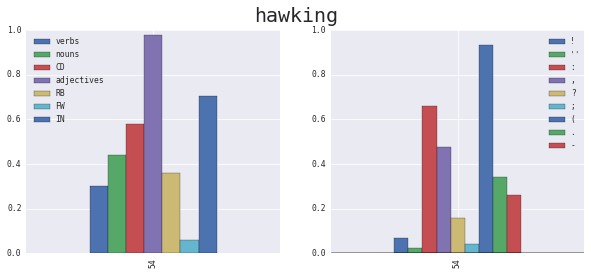

In [79]:
#generate plot of stylistic features
#data = pd.read_csv("features.csv")
pos_viz = ['verbs', 'nouns', 'CD', 'adjectives', 'RB', 'FW', 'IN']
punct_viz = ['!', "''", ':', ',', "?", ';', '(', '.', '-']
data['verbs'] = verbs
data['nouns'] = nouns 
data['adjectives'] = adjectives
desired_name = ['hawking']

for i in range(len(names)):
    if names[i] in desired_name:
        data_viz1 = data[pos_viz][i:i+1] #get one observation with just these columns
        data_viz2 = data[punct_viz][i:i+1] 
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
        plt.suptitle(names[i], fontsize=20)
        data_viz1.plot(ax=axes[0], kind='bar').set_ylim(0,1); plt.axhline(0, color='k')
        data_viz2.plot(ax=axes[1], kind='bar').set_ylim(0,1); plt.axhline(0, color='k')

### From the above information we gather a detailed profile of Stephen Hawking as a writer. We now know the topics he writes about, which authors he writes similar to, and what his syle profile looks like. From individual-author analysis such as this to population-wide analysis such as that before, these techniques present an interesting opportunity to understand what makes an author or work of literature unique, in a way that we do not typically understand it by simply reading the text.